[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os

# Directly set your Roboflow API key
os.environ["ROBOFLOW_API_KEY"] = "wGYGwTjglhST7mybt9qF"


### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Wed Apr 23 05:48:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 68.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [5]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-04-23 05:51:17--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-04-23 05:51:17 (92.5 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

## Download dataset from Roboflow Universe

In [6]:
from roboflow import Roboflow

# Initialize Roboflow
rf = Roboflow(api_key="wGYGwTjglhST7mybt9qF")

# Load your workspace and project
project = rf.workspace("da-mec7y").project("cataract-finder-nups1")

# Get the version you want (e.g., version 1) and specify format as 'yolov12'
dataset = project.version(1).download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cataract-finder-1 in yolov12:: 100%|██████████| 1073/1073 [00:01<00:00, 911.89it/s] 


In [7]:
!ls {dataset.location}

data.yaml  README.roboflow.txt	test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [8]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [9]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 2
names: ['cataract', 'normal']

roboflow:
  workspace: da-mec7y
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [11]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=50)

New https://pypi.org/project/ultralytics/8.3.114 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/cataract-finder-1/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fals

100%|██████████| 5.26M/5.26M [00:00<00:00, 92.6MB/s]


AMP: checks passed ✅


train: Scanning /content/cataract-finder-1/train/labels... 388 images, 0 backgrounds, 0 corrupt: 100%|██████████| 388/388 [00:00<00:00, 2454.01it/s]

train: New cache created: /content/cataract-finder-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/cataract-finder-1/valid/labels... 92 images, 0 backgrounds, 0 corrupt: 100%|██████████| 92/92 [00:00<00:00, 943.12it/s]

val: New cache created: /content/cataract-finder-1/valid/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      6.79G      3.014      4.363       4.25         11        640: 100%|██████████| 25/25 [00:17<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]

                   all         92         94   0.000884      0.365    0.00188   0.000665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.69G      2.916      4.244      4.155          6        640: 100%|██████████| 25/25 [00:14<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         92         94   0.000815      0.332    0.00214   0.000858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.88G       2.93      3.924      3.848          7        640: 100%|██████████| 25/25 [00:14<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]

                   all         92         94   0.000815      0.332    0.00818    0.00404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.71G      2.775      3.641      3.526          8        640: 100%|██████████| 25/25 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         92         94     0.0031      0.298     0.0197    0.00512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.69G      2.759      3.427      3.371          9        640: 100%|██████████| 25/25 [00:13<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]

                   all         92         94       0.54     0.0222      0.011    0.00179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.89G      2.811      3.162      3.312         12        640: 100%|██████████| 25/25 [00:14<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all         92         94      0.135      0.162     0.0836     0.0348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.89G       2.78      2.929       3.24          7        640: 100%|██████████| 25/25 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all         92         94      0.754      0.224      0.301      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.88G      2.697      2.759      3.198          5        640: 100%|██████████| 25/25 [00:13<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         92         94      0.452      0.398      0.347      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.69G       2.64      2.569      3.123          7        640: 100%|██████████| 25/25 [00:13<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         92         94      0.559      0.333      0.351      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.72G      2.486      2.423      2.991         12        640: 100%|██████████| 25/25 [00:14<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]

                   all         92         94      0.671      0.545      0.629      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.88G      2.353      2.281      2.918          4        640: 100%|██████████| 25/25 [00:14<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]

                   all         92         94      0.547      0.601      0.549      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.72G      2.266      2.065      2.833         13        640: 100%|██████████| 25/25 [00:13<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         92         94       0.73      0.448      0.634      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.69G      2.183      2.049      2.773          5        640: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         92         94      0.679      0.582      0.661      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.87G      2.178       2.06      2.768         10        640: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all         92         94      0.772      0.612       0.72      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.88G      2.064      1.898      2.671          9        640: 100%|██████████| 25/25 [00:13<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         92         94      0.913      0.724      0.869      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.88G      1.963       1.77      2.569          6        640: 100%|██████████| 25/25 [00:13<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all         92         94      0.807      0.706      0.778      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.69G       1.98      1.746      2.537          7        640: 100%|██████████| 25/25 [00:14<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all         92         94      0.752      0.756      0.786      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.72G      1.903      1.674      2.486          9        640: 100%|██████████| 25/25 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         92         94      0.979      0.903      0.939      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.72G      1.838      1.645      2.401          9        640: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all         92         94      0.758      0.725      0.782      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.88G      1.702      1.532      2.308         12        640: 100%|██████████| 25/25 [00:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all         92         94      0.857      0.799      0.897      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.69G      1.719      1.529      2.337          6        640: 100%|██████████| 25/25 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         92         94      0.809      0.884      0.876      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.89G      1.654       1.43      2.269          9        640: 100%|██████████| 25/25 [00:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]

                   all         92         94      0.861      0.913      0.917      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.88G      1.613      1.395      2.222         10        640: 100%|██████████| 25/25 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         92         94      0.916      0.876      0.928      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.88G      1.611      1.348      2.165          8        640: 100%|██████████| 25/25 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         92         94      0.904      0.756      0.889       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.69G      1.587       1.31      2.136          7        640: 100%|██████████| 25/25 [00:13<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all         92         94       0.94      0.853      0.915      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.72G      1.553      1.246      2.145         13        640: 100%|██████████| 25/25 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         92         94      0.965      0.836       0.92       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.72G       1.55      1.329      2.092          7        640: 100%|██████████| 25/25 [00:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all         92         94      0.964      0.894      0.931      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.88G      1.466      1.224      2.051         11        640: 100%|██████████| 25/25 [00:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all         92         94      0.942      0.813      0.887      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.69G      1.421       1.13      2.002         11        640: 100%|██████████| 25/25 [00:13<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         92         94       0.89       0.93       0.94      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.89G      1.533      1.216      2.102         11        640: 100%|██████████| 25/25 [00:13<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         92         94      0.958       0.86      0.941      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.72G       1.44       1.14      2.013          7        640: 100%|██████████| 25/25 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all         92         94      0.931      0.865      0.925      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.88G      1.462      1.189       2.04          6        640: 100%|██████████| 25/25 [00:13<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         92         94       0.86      0.919      0.934      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      6.69G      1.426      1.113      1.991         10        640: 100%|██████████| 25/25 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         92         94      0.945      0.848      0.937      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.72G      1.357      1.111      1.927          5        640: 100%|██████████| 25/25 [00:13<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]

                   all         92         94      0.971       0.86      0.937      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.72G      1.352      1.053       1.93         13        640: 100%|██████████| 25/25 [00:14<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all         92         94      0.896       0.92      0.932      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.88G      1.333       1.04      1.905         12        640: 100%|██████████| 25/25 [00:13<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

                   all         92         94      0.946      0.936      0.953      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      6.69G      1.346      1.056      1.908         11        640: 100%|██████████| 25/25 [00:13<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         92         94      0.958      0.906      0.948      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      6.89G       1.38      1.062       1.94          9        640: 100%|██████████| 25/25 [00:13<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         92         94      0.958      0.922      0.952      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      6.72G      1.302      1.066      1.886         13        640: 100%|██████████| 25/25 [00:13<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]

                   all         92         94      0.994      0.939      0.954      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.88G      1.261      1.009      1.838         10        640: 100%|██████████| 25/25 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

                   all         92         94      0.994      0.934      0.957      0.611


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.69G       1.19     0.9164      1.844          5        640: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         92         94      0.936      0.923      0.952       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.87G      1.138     0.8256      1.811          4        640: 100%|██████████| 25/25 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         92         94      0.966       0.89      0.942      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      6.71G      1.102      0.803      1.757          4        640: 100%|██████████| 25/25 [00:14<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]

                   all         92         94      0.983      0.934      0.956      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      6.88G      1.148      0.805      1.813          4        640: 100%|██████████| 25/25 [00:14<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.46it/s]

                   all         92         94      0.952      0.946      0.954      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.69G      1.097     0.8084      1.741          4        640: 100%|██████████| 25/25 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         92         94      0.979      0.919      0.956      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.87G      1.075     0.7667       1.73          4        640: 100%|██████████| 25/25 [00:14<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]

                   all         92         94      0.993      0.945      0.957      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.88G      1.039      0.754      1.714          4        640: 100%|██████████| 25/25 [00:13<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         92         94      0.954      0.957      0.954      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      6.88G      1.062     0.7669      1.707          4        640: 100%|██████████| 25/25 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all         92         94          1      0.929      0.957       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      6.69G      1.035     0.7348      1.694          4        640: 100%|██████████| 25/25 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         92         94      0.968      0.953      0.956      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.87G      1.036     0.7312      1.695          4        640: 100%|██████████| 25/25 [00:14<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         92         94      0.972      0.957      0.956      0.649



50 epochs completed in 0.237 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 18.6MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,982 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


                   all         92         94      0.972      0.957      0.956      0.649
              cataract         45         45      0.943          1      0.993      0.747
                normal         49         49          1      0.914      0.919      0.552
Speed: 0.2ms preprocess, 7.8ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/train2


## Evaluate fine-tuned YOLOv12 model

In [12]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml  weights


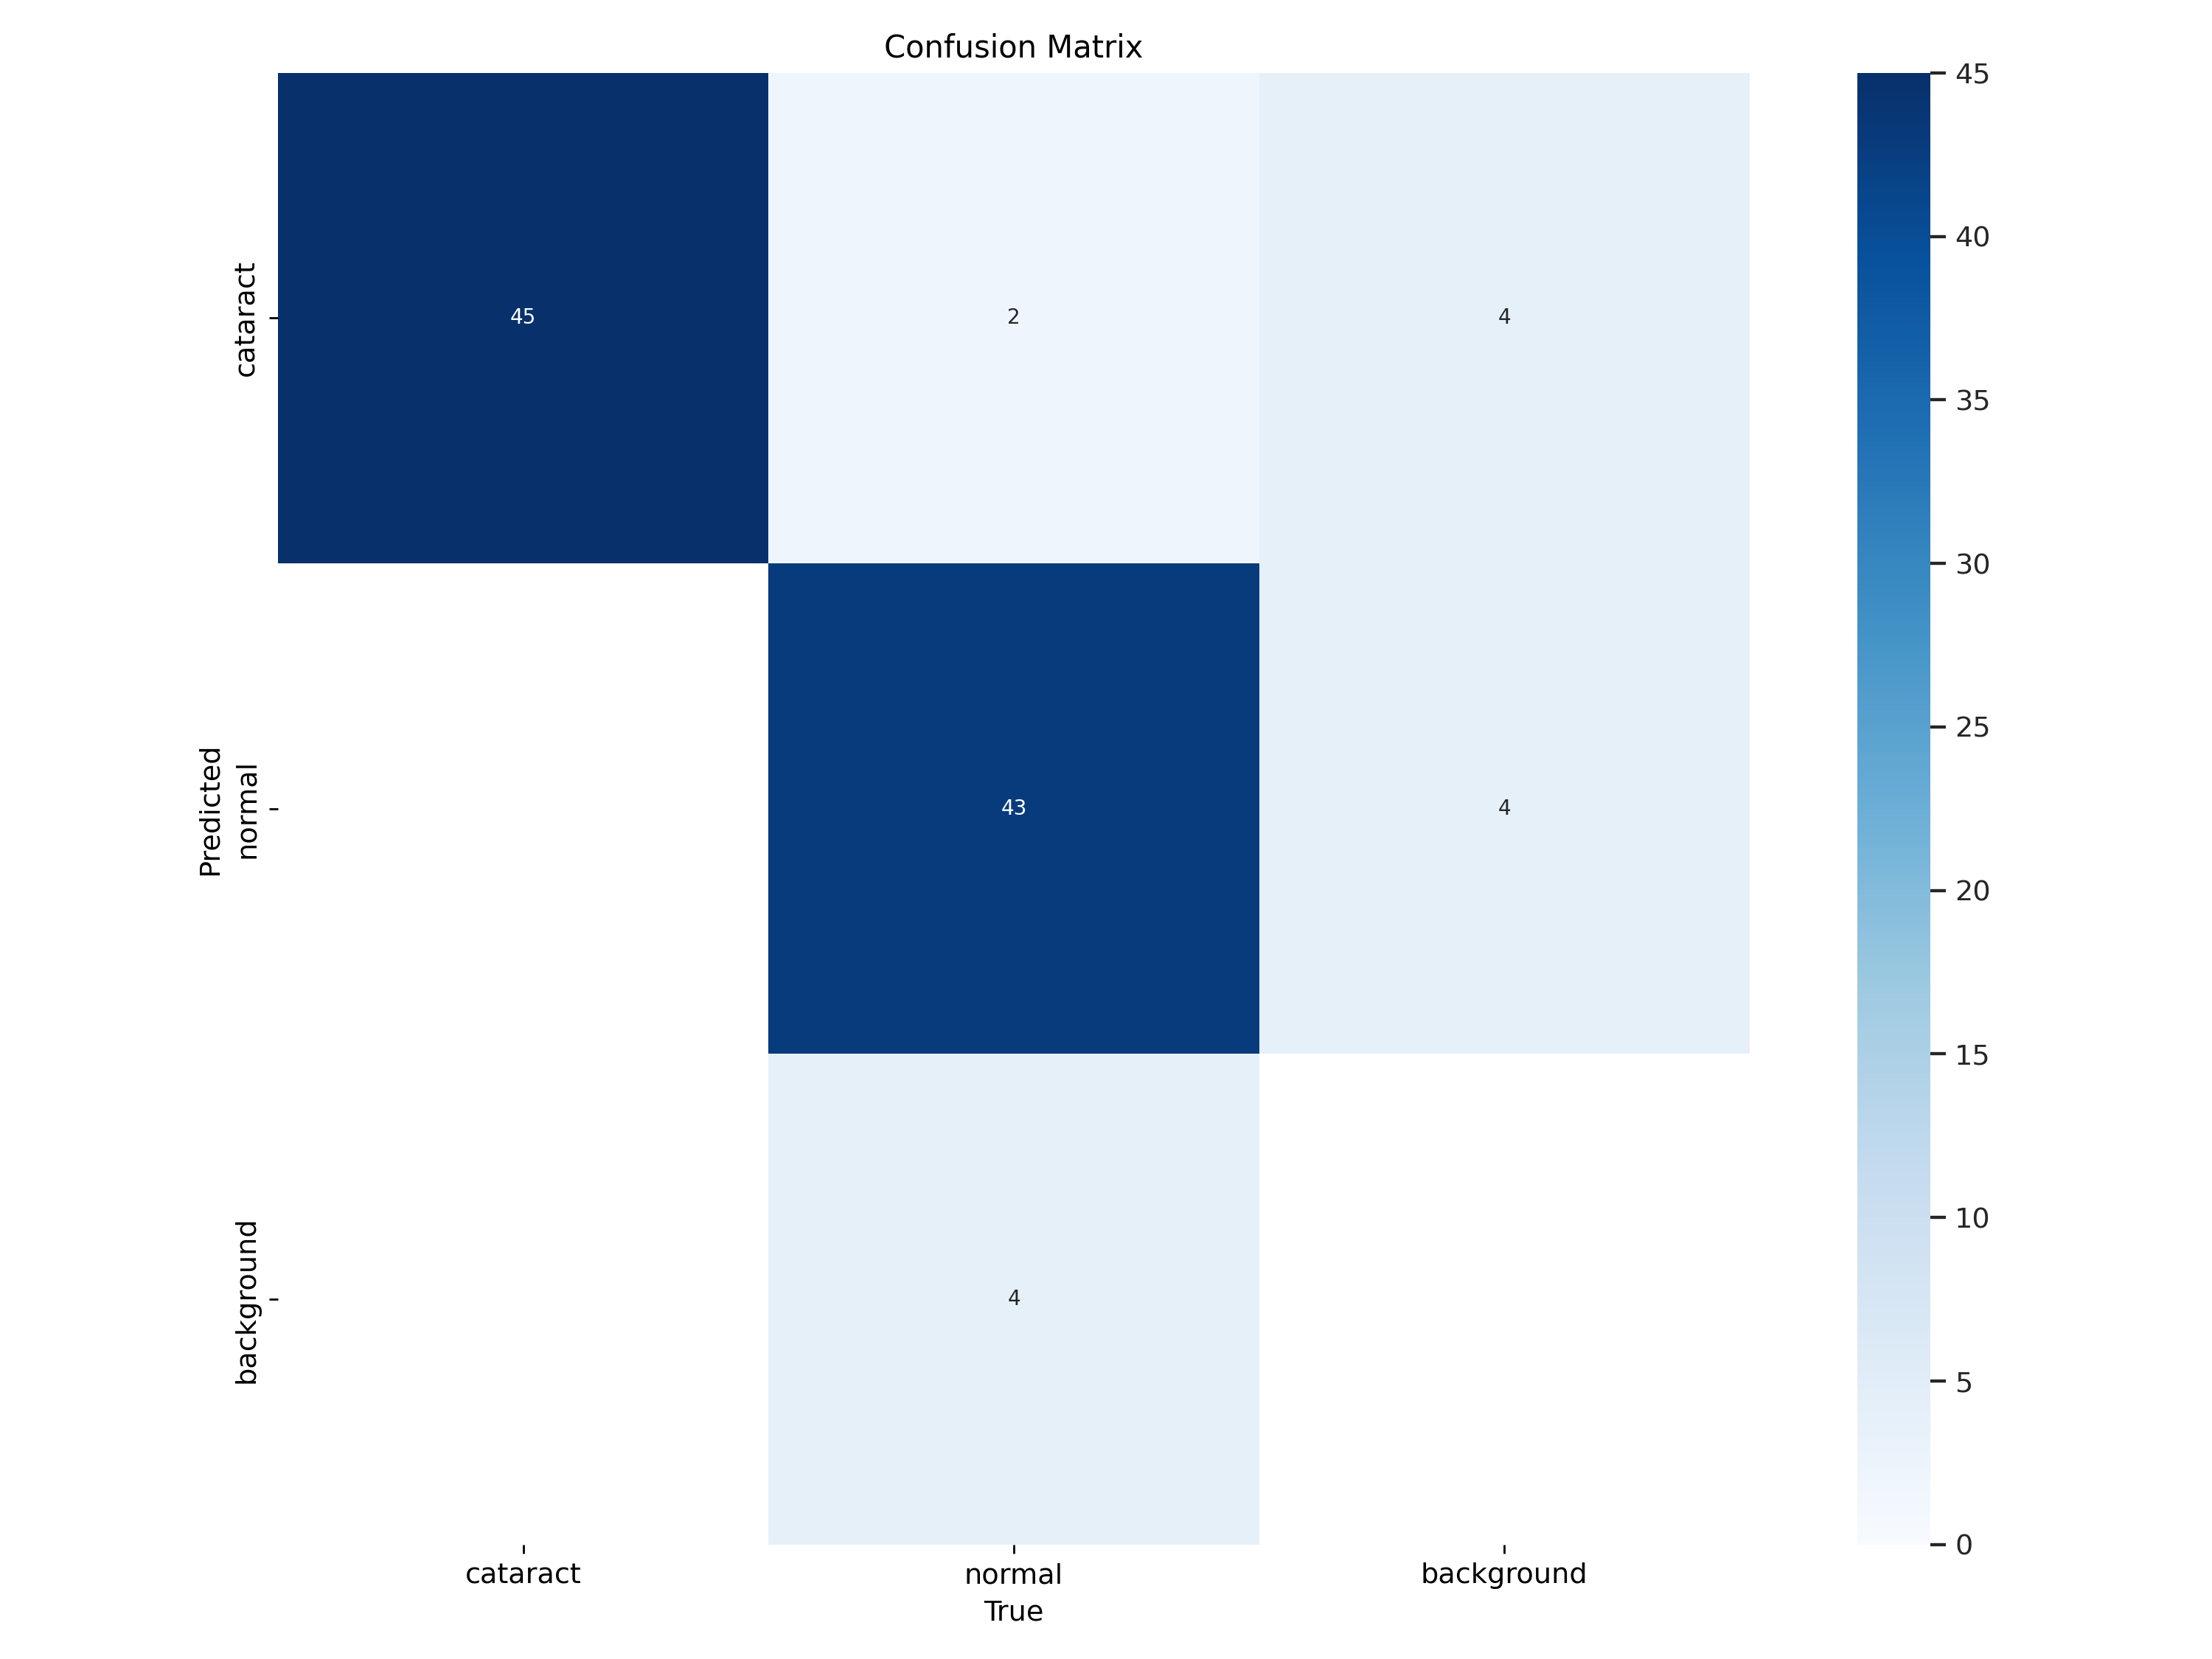

In [15]:
from IPython.display import Image

Image(filename='/content/runs/detect/train2/confusion_matrix.png', width=1000)


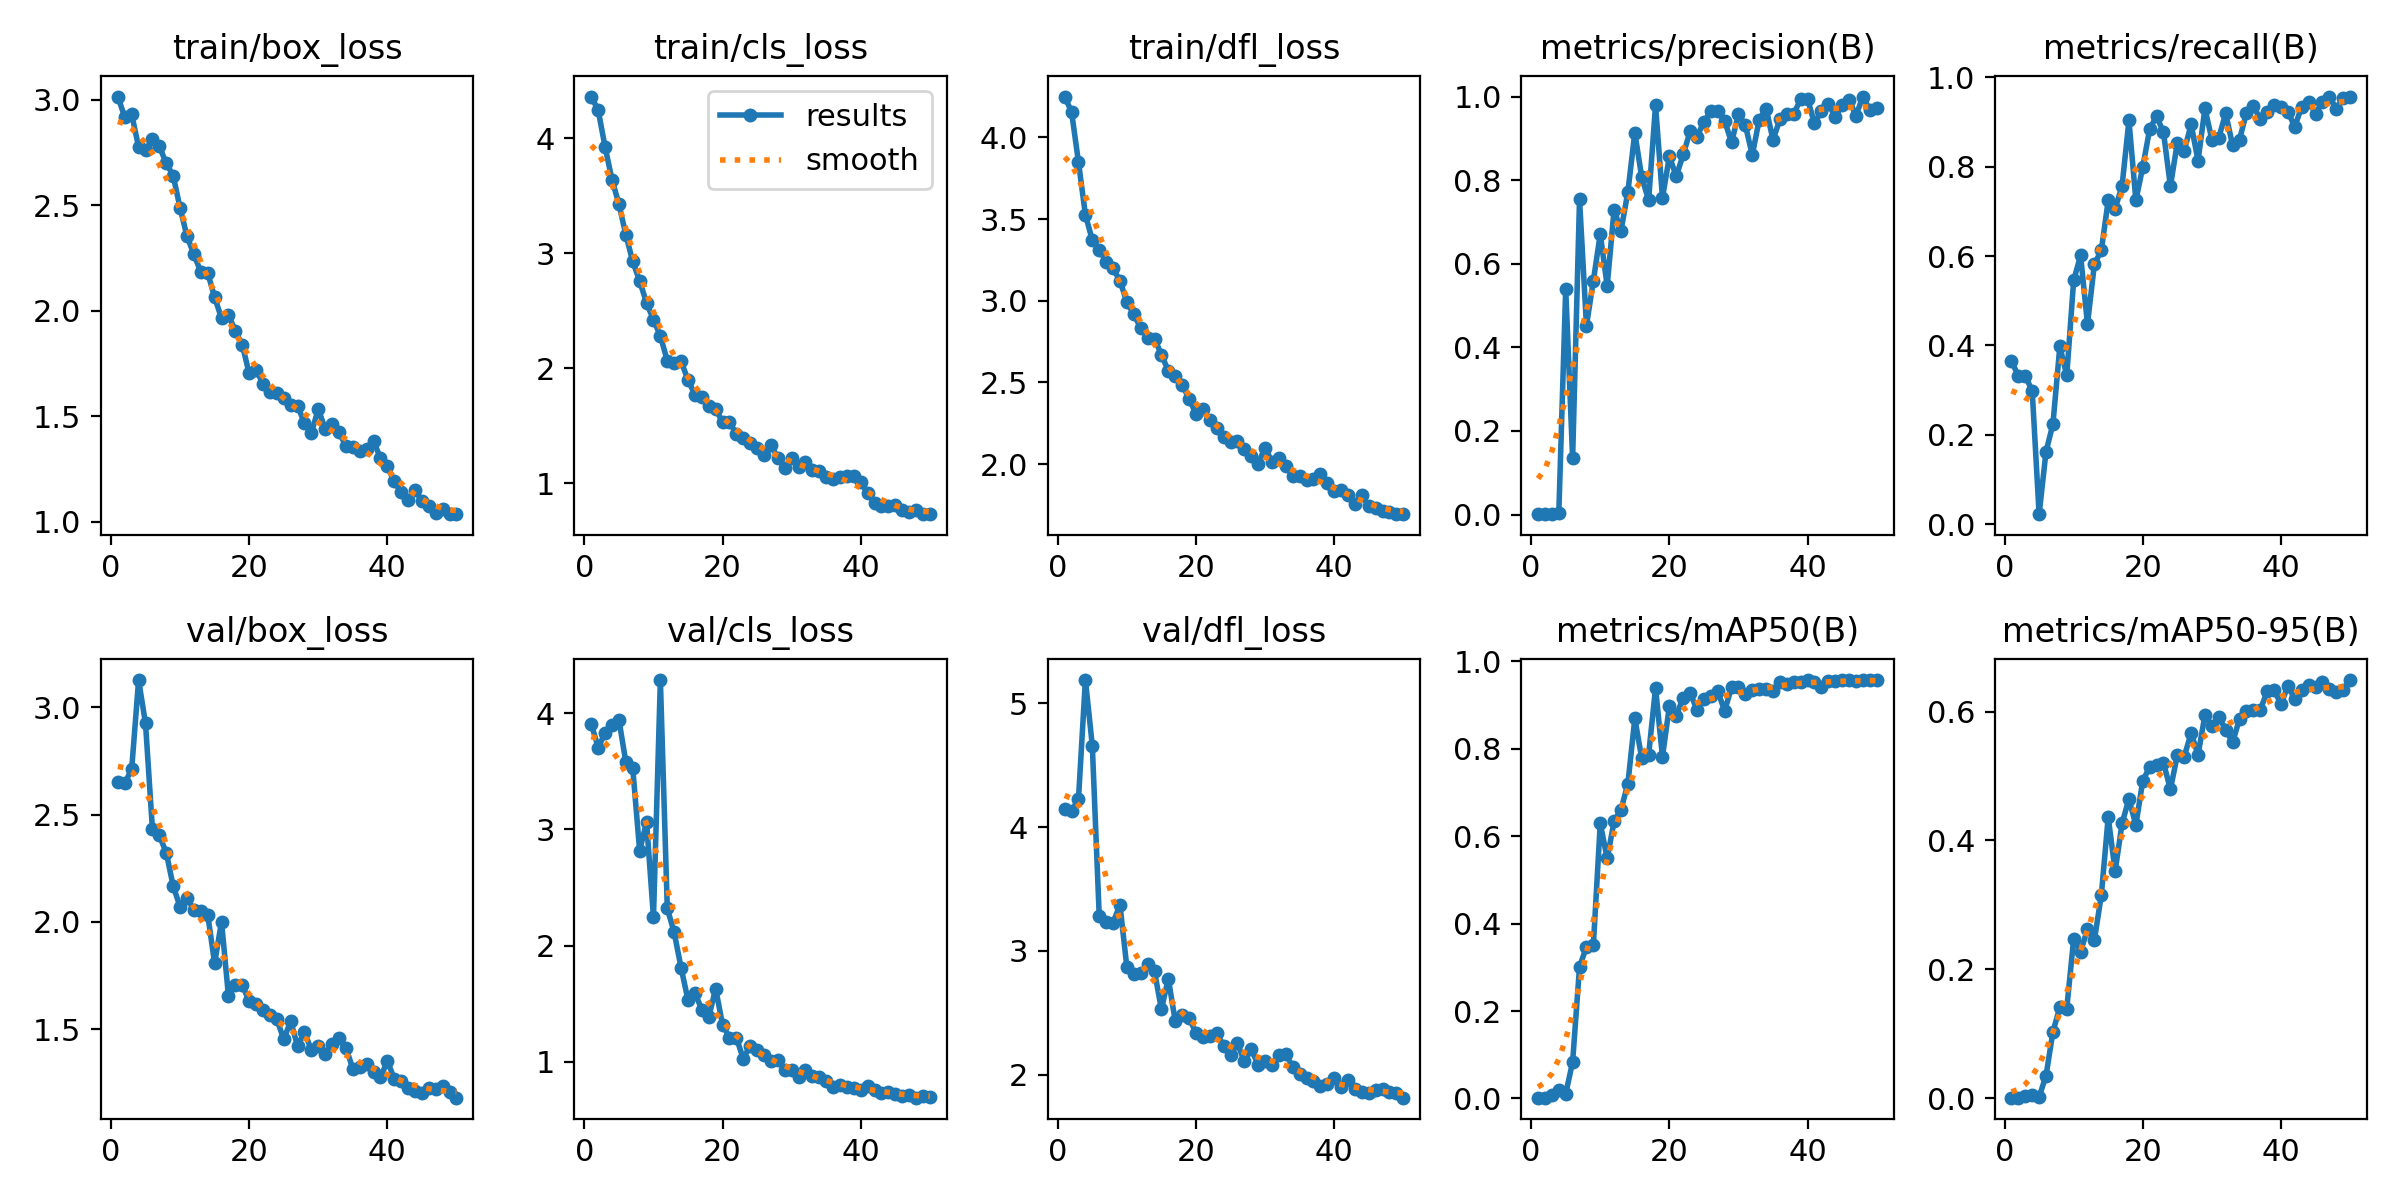

In [17]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train2/results.png', width=1000)

In [18]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['cataract', 'normal']

In [21]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [22]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.5901339855431716
mAP 50 0.8748743335872048
mAP 75 0.6924514400658233


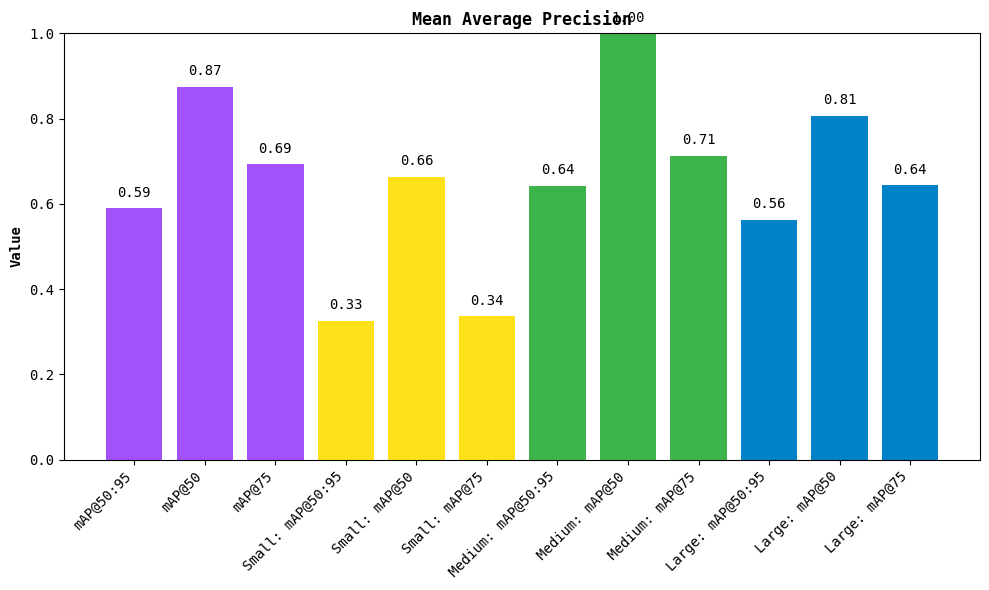

In [23]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [24]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train2/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

In [51]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import cv2
from ultralytics import YOLO
import supervision as sv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Step 1: Setup CNN classifier training on cropped data ---

data_dir = '/content/cropped_data'  # folder with subfolders per class

# Define transforms for training and validation
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split dataset into train and val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

num_classes = len(dataset.classes)
print(f"Classes: {dataset.classes}")

# Initialize model
cnn_model = models.resnet18(weights=None)
cnn_model.fc = nn.Linear(cnn_model.fc.in_features, num_classes)
cnn_model = cnn_model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-4)

# Train function
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

# Validation function
def eval_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

# Training loop
epochs = 5
for epoch in range(epochs):
    train_loss, train_acc = train_epoch(cnn_model, train_loader, optimizer, criterion)
    val_loss, val_acc = eval_epoch(cnn_model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

# Save CNN model weights
torch.save(cnn_model.state_dict(), "/content/cnn_cataract_classifier.pth")
print("CNN severity classifier saved at /content/cnn_cataract_classifier.pth")

# --- Step 2: Load YOLOv12 model for detection ---
yolo_model_path = "/content/runs/detect/train2/weights/best.pt"
yolo_model = YOLO(yolo_model_path)

# Load CNN classifier for inference
cnn_model.load_state_dict(torch.load("/content/cnn_cataract_classifier.pth", map_location=device))
cnn_model.eval()

# --- Step 3: Inference on one image and classify detected cataracts severity ---

import numpy as np

def classify_crop(crop_img):
    # Transform crop for CNN input
    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
    pil_img = transforms.ToPILImage()(crop_img)
    input_tensor = transform(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = cnn_model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
    return dataset.classes[pred]

# Load image for testing
test_image_path = "/content/cataract-finder-1/valid/images/image_118_png.rf.e1bad06ae55461f083800b0761a67f85.jpg"
image = cv2.imread(test_image_path)

# YOLO detection
results = yolo_model(image)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

# Annotate and classify detections
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
for box in detections.xyxy:
    x1, y1, x2, y2 = map(int, box)
    crop = image[y1:y2, x1:x2]
    severity = classify_crop(crop)
    label = f"{severity}"
    # Annotate box and label on image
    annotated_image = box_annotator.annotate(annotated_image, sv.Detections(xyxy=[box]))
    annotated_image = label_annotator.annotate(annotated_image, sv.Detections(xyxy=[box], labels=[label]))

# Show annotated image
sv.plot_image(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))


FileNotFoundError: Found no valid file for the classes mild, moderate, severe. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [49]:
# Full pipeline: YOLOv12 detection + crop + CNN classifier train + inference

import os
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets
from ultralytics import YOLO
import supervision as sv
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === CONFIG ===
yolo_model_path = "/content/runs/detect/train2/weights/best.pt"  # Your trained YOLOv12 weights
image_folder = "/content/cataract-finder-1/train/images"         # Folder with images for cropping
cropped_data_path = "/content/cropped_data"                      # Folder where cropped images for CNN will be saved
cnn_weights_path = "/content/cnn_cataract_classifier.pth"        # CNN weights file

# Create cropped_data dirs if not exist
for cls in ['mild', 'moderate', 'severe']:
    os.makedirs(os.path.join(cropped_data_path, cls), exist_ok=True)

# === STEP 1: Load YOLOv12 model for detection ===
yolo_model = YOLO(yolo_model_path)

# === STEP 2: Detect and crop images to build CNN training data ===
def crop_and_save_detections():
    print("Detecting and cropping cataracts from images...")

    img_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    count = 0
    for img_file in img_files:
        img_path = os.path.join(image_folder, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        results = yolo_model(img)[0]
        boxes = results.boxes.xyxy.cpu().numpy()
        scores = results.boxes.conf.cpu().numpy()
        classes = results.boxes.cls.cpu().numpy().astype(int)

        # Filter by confidence threshold (e.g. 0.5)
        keep_indices = np.where(scores > 0.5)[0]

        for i in keep_indices:
            x1, y1, x2, y2 = boxes[i].astype(int)
            cls = classes[i]

            # Map YOLO class IDs to severity labels (assuming 0: mild,1: moderate,2: severe)
            # Adjust according to your dataset classes!
            label_map = {0: 'mild', 1: 'moderate', 2: 'severe'}
            if cls not in label_map:
                continue

            cropped_img = img[y1:y2, x1:x2]
            save_dir = os.path.join(cropped_data_path, label_map[cls])
            save_path = os.path.join(save_dir, f"{os.path.splitext(img_file)[0]}_{count}.jpg")
            cv2.imwrite(save_path, cropped_img)
            count += 1

    print(f"Cropping done! Total cropped images saved: {count}")

# Uncomment this to run cropping (only once to build dataset)
# crop_and_save_detections()

# === STEP 3: Define CNN classifier model ===
def get_cnn_model(num_classes=3):
    model = models.resnet18(weights=None)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# === STEP 4: Train CNN classifier on cropped data ===
def train_cnn_classifier(cropped_data_path, model, epochs=5, batch_size=16):
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])

    dataset = datasets.ImageFolder(cropped_data_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

    torch.save(model.state_dict(), cnn_weights_path)
    print(f"Model saved to {cnn_weights_path}")

# Uncomment this line to train CNN classifier (after cropping dataset is ready)
# cnn_model = get_cnn_model()
# train_cnn_classifier(cropped_data_path, cnn_model, epochs=5)

# === STEP 5: Load CNN model for inference ===
def load_cnn_classifier(num_classes=3):
    model = get_cnn_model(num_classes)
    model.load_state_dict(torch.load(cnn_weights_path, map_location=device))
    model.eval()
    return model

# === STEP 6: Run detection + classification on new images and visualize ===
def detect_and_classify(image_path, yolo_model, cnn_model):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = yolo_model(img_rgb)[0]
    boxes = results.boxes.xyxy.cpu().numpy()
    scores = results.boxes.conf.cpu().numpy()
    classes = results.boxes.cls.cpu().numpy().astype(int)

    label_map = {0: 'mild', 1: 'moderate', 2: 'severe'}
    cnn_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])

    annotated_img = img_rgb.copy()
    for i, box in enumerate(boxes):
        if scores[i] < 0.5:
            continue
        x1, y1, x2, y2 = box.astype(int)

        # Crop region, classify severity with CNN
        crop = img_rgb[y1:y2, x1:x2]
        if crop.size == 0:
            continue
        input_tensor = cnn_transform(crop).unsqueeze(0).to(device)

        with torch.no_grad():
            output = cnn_model(input_tensor)
            pred_label_idx = output.argmax(dim=1).item()

        pred_label = label_map.get(pred_label_idx, "unknown")
        conf_text = f"{pred_label} ({scores[i]:.2f})"

        # Draw box and label on image
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.putText(annotated_img, conf_text, (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)

    # Convert back to BGR for OpenCV display if needed
    annotated_img_bgr = cv2.cvtColor(annotated_img, cv2.COLOR_RGB2BGR)
    cv2.imshow("Detection + Classification", annotated_img_bgr)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# === USAGE EXAMPLE ===

# 1) Run this once to crop dataset (uncomment if you want to generate cropped data)
# crop_and_save_detections()

# 2) Train CNN classifier (after cropping dataset is ready)
# cnn_model = get_cnn_model()
# train_cnn_classifier(cropped_data_path, cnn_model, epochs=5)

# 3) Load CNN classifier for inference
# cnn_model = load_cnn_classifier()

# 4) Run detection + classification on new image
# test_image_path = "/content/cataract-finder-1/valid/images/image_118_png.rf.e1bad06ae55461f083800b0761a67f85.jpg"
# detect_and_classify(test_image_path, yolo_model, cnn_model)


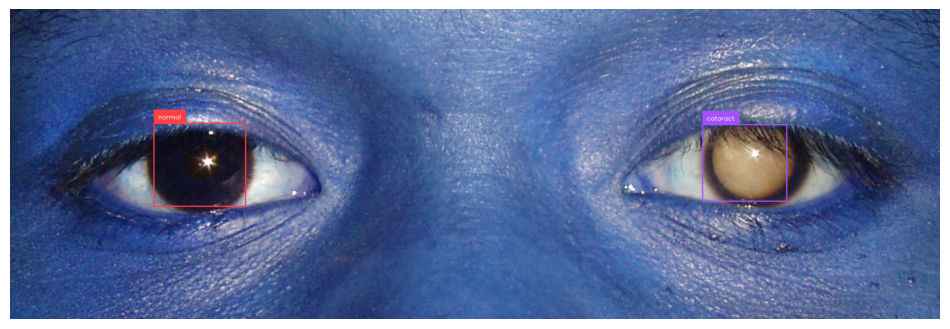

In [37]:
import cv2
import supervision as sv  # assuming you're using Supervision for annotations

# Custom image path
image_path = "/content/cataract-finder-1/valid/images/image_145_png.rf.ed20a75a9350cabf6184196cf5b0f3d1.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run inference
results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

# Annotate image
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# Display annotated image
sv.plot_image(annotated_image)
